### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'PMG 287 monitoring'

In [4]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_1000/all.csv',
                'PMG 284 monitoring': '../data/PMG_284/seria1.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_1000/preprocessed_saccharose.csv', 
                                            '../data/saccharose_1000/preprocessed_glucose.csv',
                                            '../data/saccharose_1000/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_substrate0.csv',
                                      '../data/PMG_284/preprocessed_substrate1.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_substrate0.csv',
                                      '../data/PMG_287/preprocessed_substrate1.csv',
                                      '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_1000/comparing_with_first/',
                'PMG 284 monitoring': '../results/PMG_284/comparing_with_first/',
                'PMG 287 monitoring': '../results/PMG_287/comparing_with_first/'}

components_figures_path = '../components_figures/'

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [6]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [7]:
mixture_time_data.columns = names

In [8]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [9]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [10]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [11]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [13]:
%matplotlib notebook

In [14]:
reagents_spectra

<IPython.core.display.Javascript object>


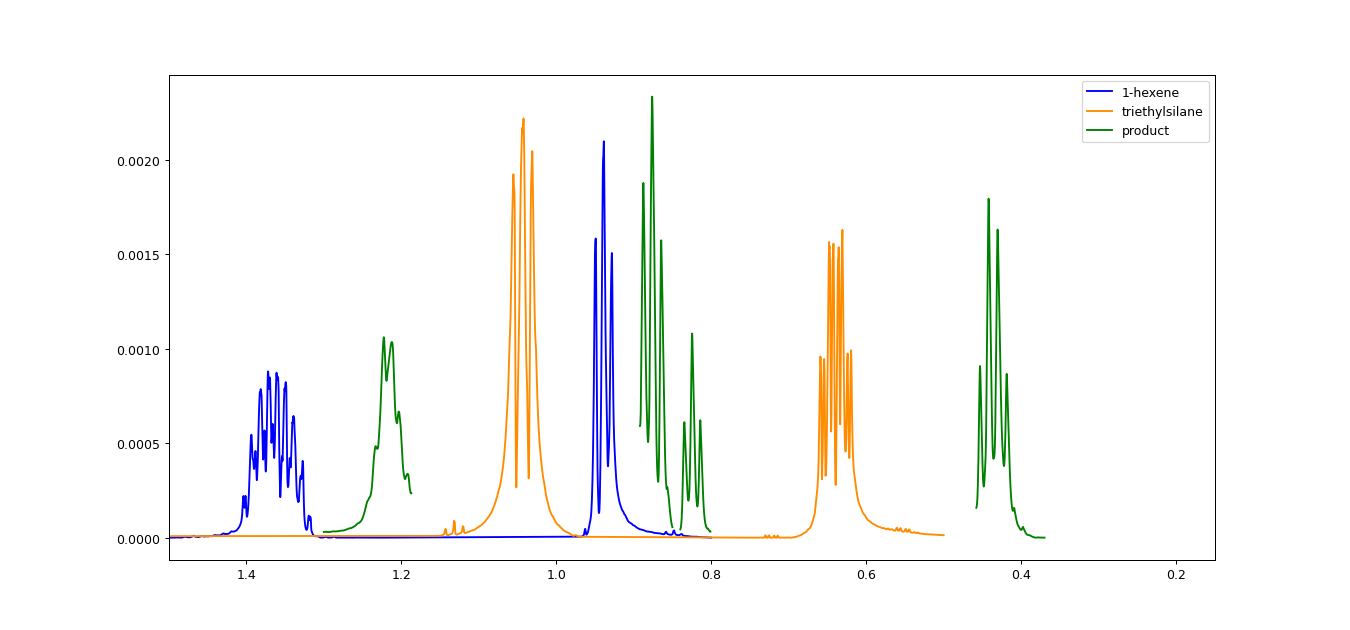

In [15]:
sp = reagents_spectra[0]
ppm = np.array(sp.confs)[:,0]
ints = np.array(sp.confs)[:,1]

sp2 = reagents_spectra[1]
ppm2 = np.array(sp2.confs)[:,0]
ints2 = np.array(sp2.confs)[:,1]

sp3 = reagents_spectra[2]
ppm3 = np.array(sp3.confs)[:,0]
ints3 = np.array(sp3.confs)[:,1]

# 284 product
# area1 = np.logical_and(np.array(sp3.confs)[:,0]>0.622, np.array(sp3.confs)[:,0]<0.672)
# area2 = np.logical_and(np.array(sp3.confs)[:,0]>0.84, np.array(sp3.confs)[:,0]<0.92)
# area3 = np.logical_and(np.array(sp3.confs)[:,0]>0.95, np.array(sp3.confs)[:,0]<1.01)
# area4 = np.logical_and(np.array(sp3.confs)[:,0]>1.042, np.array(sp3.confs)[:,0]<1.09)
# area5 = np.logical_and(np.array(sp3.confs)[:,0]>1.22, np.array(sp3.confs)[:,0]<1.38)
# area6 = np.logical_and(np.array(sp3.confs)[:,0]>1.4, np.array(sp3.confs)[:,0]<1.49)
# area7 = np.logical_and(np.array(sp3.confs)[:,0]>1.5, np.array(sp3.confs)[:,0]<1.675)

# 287 product
area1 = np.logical_and(np.array(sp3.confs)[:,0]>0.37, np.array(sp3.confs)[:,0]<0.458)
area2 = np.logical_and(np.array(sp3.confs)[:,0]>0.801, np.array(sp3.confs)[:,0]<0.84)
area3 = np.logical_and(np.array(sp3.confs)[:,0]>0.85, np.array(sp3.confs)[:,0]<0.892)
area4 = np.logical_and(np.array(sp3.confs)[:,0]>1.187, np.array(sp3.confs)[:,0]<1.3)

plt.figure(figsize=(15, 7))

plt.xlim(0.15, 1.5)

#plt.xlim(3.0, 5.5)
#plt.xlim(3.2, 3.92)


#plt.xlim(0.55, 1.9)

plt.plot(ppm, ints, label='1-hexene', color='blue') #2-pentene, saccharose, 1-hexene
plt.plot(ppm2, ints2, label='triethylsilane', color='darkorange') #glucose, triethylsilane
#plt.plot(ppm3, ints3, label='product', color='green') #fructose, product

plt.gca().invert_xaxis()


#284
# plt.plot(ppm3[area1], ints3[area1], label='product', color='green')
# plt.plot(ppm3[area2], ints3[area2], color='green')
# plt.plot(ppm3[area3], ints3[area3], color='green')
# plt.plot(ppm3[area4], ints3[area4], color='green')
# plt.plot(ppm3[area5], ints3[area5], color='green')
# plt.plot(ppm3[area6], ints3[area6], color='green')
# plt.plot(ppm3[area7], ints3[area7], color='green')

#287
plt.plot(ppm3[area1], ints3[area1], label='product', color='green')
plt.plot(ppm3[area2], ints3[area2], color='green')
plt.plot(ppm3[area3], ints3[area3], color='green')
plt.plot(ppm3[area4], ints3[area4], color='green')


plt.legend()
#plt.savefig(components_figures_path + experiment_name + '_PMG_287_0.15_1.5.png', dpi=300)